
# Создание симулятора задачи управления
Первым делом создадим симулятор задачи управления.

Пусть существует внешняя среда, которая представляет из себя непрерывное плоское поле размером 10 на 10 м.
Где-то на данном поле расположен некий точечный неподвижный целевой объект (мишень).

Пусть существует физический агент (ракета), представляющий из себя подвижную точку.

Пусть целью физического агента (ракеты) является достижение целевого объекта (мишени).

Физический агент (ракета) получает управляющие сигналы (увеличить/уменьшить тягу) от системы управления. Будем также говорить, что система управления управляет физическим агентом.

Цель управления заключается в том, чтобы обеспечить достижение физическим агентом целевого объекта за наименьшее время (наискорейшее поражение мишени ракетой).

В таком случае в качестве критерия эффективности управления может использоваться время, необходимое для достижения цели управления.

Обозначим совокупность внешней среды, физического агента и критерия эффективности управления как задачу управления.

Несмотря на концептуальную полноту, представленное определение задачи управления не позволяет получить о ней полного представления. Рассматриваемый пример задачи управления может существовать как в реальном мире, так и являться моделью.

Рассмотрим задачу правления на примере её реализации в виде компьютерной модели.

Пусть время $t$ в модели дискретно.

Состояние модели $s$ включает в себя следующие переменные:
- координаты целевого объекта (мишени) по осям x и y: $t_x$, $t_y$;
- координаты, скорости и ускорения физического агента (ракеты) по осям x и y: $p=(p_x,p_y)$, $v=(v_x,v_y)$, $a=(a_x, a_y)$.

На переменные состояния накладываются следующие ограничения:
- $t_x, t_y, p_x, p_y \in [0, 10]$;
- $v_x, v_y \in [-1, 1]$, в начальный момент времени $v_x=0, v_y=0$;
- $a_x, a_y \in [-0.5, 0.5]$, в начальный момент времени $a_x=0, a_y=0$.

Состояние $s$ модели изменяется согласно следующим законам:
$$t_x, t_y = const$$
$$p(t+1) = p(t) + v(t) + a(t)/2, $$ с учетом ограничения на диапазон возможных значений;
$$v(t+1) = v(t) + a(t),$$ с учетом ограничения на диапазон возможных значений.

Компоненты вектора $a$ являются управляемыми, т. е. их значение определяется системой управления (с учетом диапазона возможных значений). Прочие переменные состояния $s$ являются зависимыми, и их значение в следующий момент времени $s(t+1)$ определяется значениями в текущий момент времени $s(t)$ и законами функционирования модели.

Симулятор задачи управления должен выполнять следующие функции:
- инициализировать конкретныыми или случайными значениями начального состояния $s(0)$;
- хранить текущее состояние модели;
- переходить в следующее состояние модели;
- визуализировать процесс функционирования модели.

Перейдём к программной реализации симулятора задачи управления.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Индексы данных в массиве состояния
s_t_x = 0
s_t_y = 1
s_p_x = 2
s_p_y = 3
s_v_x = 4
s_v_y = 5
s_a_x = 6
s_a_y = 7
# Функция генерации случайоного начального состояния задачи управления
def get_state():
    state = np.array([
    # Случайные положения целевого объекта и агента
    np.random.uniform(0, 10), # t_x
    np.random.uniform(0, 10), # t_y
    np.random.uniform(0, 10), # p_x
    np.random.uniform(0, 10), # p_y
    # Нулевые скорости и ускорения
    0.0, # v_x
    0.0, # v_y
    0.0, # a_x
    0.0 # a_y
    ],
    # Описание "колонок" массива состояния
#     dtype=([
#     ('t_x', float), 
#     ('t_y',float), 
#     ('p_x',float), 
#     ('p_y',float), 
#     ('v_x',float), 
#     ('v_y',float), 
#     ('a_x',float), 
#     ('a_y',float)]
#     ),
    ndmin=2
    )
    return state
# Пример работы функции
get_state()

array([[4.68572217, 8.42528208, 8.09801435, 9.05071404, 0.        ,
        0.        , 0.        , 0.        ]])

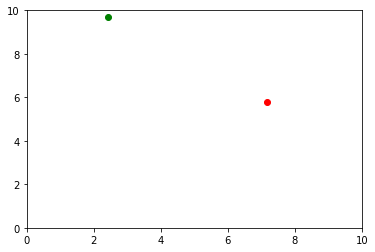

In [6]:
import ipywidgets as widgets

# Функция визуализации заданного состояния
def visualize(state):
    fig, ax = plt.subplots()
    ax.set_xlim([0,10])
    ax.set_ylim([0,10])
    # Размещаем целевой объект
    plt.scatter(state[0][s_t_x], state[0][s_t_y], color='red')
    # Размещаем агента
    plt.scatter(state[0][s_p_x], state[0][s_p_y], color='green')
    plt.show()

# Пример работы
visualize(get_state())

In [7]:
# Индексы данных в массиве действия
a_a_x = 0
a_a_y = 1
# Функция генерации случайного действия агента
def get_action():
    action = np.array(
        [
            np.random.uniform(-0.5, 0.5), # a_x
            np.random.uniform(-0.5, 0.5) # a_y
        ], 
#         dtype=(
#             [
#                 ('a_x', float),
#                 ('a_y', float)
#             ])
        ndmin=2
        )
    return action
# Пример работы
get_action()

array([[ 0.14370827, -0.35172877]])

In [8]:
# Класс среды
class Environment:
    # Конструктор 
    def __init__(self, state=None):
        # Если начальное состояние задано
        if state is None:
            self.state = get_state()
        else:
            self.state = state
    
    # Сброс среды в случайное начальное состояние
    def reset(self):
        self.state = get_state()
        return self.state

    # Получение текущего состояния
    def get_state(self):
        return copy.deepcopy(self.state)
    
    # Переход в следующее состояние
    def step(self, action):
        state = self.state
        state[0][s_a_x] = np.clip(action[0][a_a_x], -0.5, 0.5)
        state[0][s_a_y] = np.clip(action[0][a_a_y], -0.5, 0.5)
        state[0][s_p_x] = state[0][s_p_x] + state[0][s_v_x] + state[0][s_a_x] / 2
        state[0][s_p_x] = np.clip(state[0][s_p_x], 0, 10)
        state[0][s_p_y] = state[0][s_p_y] + state[0][s_v_y] + state[0][s_a_y] / 2
        state[0][s_p_y] = np.clip(state[0][s_p_y], 0, 10)
        state[0][s_v_x] = state[0][s_v_x] + state[0][s_a_x]
        state[0][s_v_x] = np.clip(state[0][s_v_x], -1, 1)
        state[0][s_v_y] = state[0][s_v_y] + state[0][s_a_y]
        state[0][s_v_y] = np.clip(state[0][s_v_y], -1, 1)
        return self.state

# Пример работы
Environment().get_state()

array([[5.6014635 , 8.88794964, 2.35862789, 7.87953531, 0.        ,
        0.        , 0.        , 0.        ]])

In [9]:
# Абстрактный класс агента, который должен возвращать действие в зависимости от состояния.
class Agent:
    def get_action(self, state):
         raise NotImplementedError("Функция выбора действия не реализована!")

# Рандомный агент. Возвращает случайное действие, реализован в целях тестирования.
class RandomAgent(Agent):
    def get_action(self, state):
         return get_action()

# Пример работы
RandomAgent().get_action(get_state())

array([[ 0.17633055, -0.43403804]])

In [10]:
# Функция симуляции эпизода из 20 шагов
def simulate(agent_fn, ep_length=20, reward_fn=None, visualization=False):
    env = Environment()
        
    # Выполняем один прогон на 10 шагов и записываем состояния среды
    state = env.get_state() # Получаем начальное состояние
    buffer = [state] # Записываем начальное состояние в буффер
    ret = 0 # сокращение от return
    for i in range(ep_length):
        action = agent_fn(state)
        env.step(action)
        new_state = env.get_state()
        buffer = buffer + [new_state]
        if reward_fn is not None:
            reward, done = reward_fn(new_state)
            ret += reward
        state = new_state
    
    # Интерфейс для управления визуализацией
    if visualization:
        play = widgets.Play(
            interval=1000,
            value=0,
            min=0,
            max=ep_length,
            step=1,
            description="Press play",
            disabled=False
        )
        slider = widgets.IntSlider(
            value=0,
            min=0,
            max=ep_length)
        widgets.jslink((play, 'value'), (slider, 'value'))
        combo = widgets.HBox([play, slider])
        display(combo)
        visualize_step = lambda step: visualize(buffer[step]) 
        w = widgets.interactive(visualize_step, step=slider)
        display(w.children[-1])
        
    if reward_fn is not None:
        return ret
    else:
        return None

# Пример работы
simulate(RandomAgent().get_action, visualization=True)

Output()

In [11]:
# Функция вычисления награды для заданного состояния
def reward_fn(state):
    position = np.array((state[0][s_p_x], state[0][s_p_y]))
    target = np.array((state[0][s_t_x], state[0][s_t_y]))
    distance = np.linalg.norm(target - position) # Длина вектора
    rew = -distance
    if distance < 2:
        done = np.array([True], ndmin=2)
    else:
        done = np.array([False], ndmin=2)
    return rew, done

# Проверка работы
reward_fn(get_state())

(-2.7276373278335533, array([[False]]))

In [12]:
# Функция вычисления среднего вознаграждения
def evaluate(ep_num, name, agent_fn):
    returns = np.zeros(ep_num)
    for ep in range(ep_num):
        ret = simulate(agent_fn=agent_fn, ep_length=20, reward_fn=reward_fn, visualization=False)
        returns[ep] = ret
    print(name,'average return:', np.mean(returns))

# Проверка работы на примере случайного агента
evaluate(ep_num=1000, name='Random agent', agent_fn=RandomAgent().get_action)

Random agent average return: -120.14991207483952


# Создание нейросетевого агента
Входными данными для нейросети являются 8 переменных состояния.

Выходными данными является вектор проекций ускорения из двух элементов с диапазоном значений $[-0.5, 0.5]$.

Нейросеть должна иметь 8 входов, 2 выхода, три скрытых нейронных слоя и функцию нормализации для приведения выходных значений к диапазону $[-0.5, 0.5]$.

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Агент на основе ИНС. Без обучения похож на случайного
class DeepAgent(Agent):
    def __init__(self):
        self.policy = self.create_policy()
        self.target_policy = tf.keras.models.clone_model(self.policy)
        self.target_policy.set_weights(self.policy.get_weights()) 

        self.critic = self.create_critic()
        self.target_critic = tf.keras.models.clone_model(self.critic)
        self.target_critic.set_weights(self.critic.get_weights())
    
    def get_action(self, state):
        action = self.policy(state)
        return action
    
    def create_policy(self):
        input_layer = tf.keras.layers.Input(shape=(8,), name="input")
        layer1 = tf.keras.layers.Dense(32, activation='sigmoid', name="layer1")(input_layer)
        layer2 = tf.keras.layers.Dense(32, activation='sigmoid', name="layer2")(layer1)
        layer3 = tf.keras.layers.Dense(2, activation='sigmoid', name="layer3")(layer2)
        out = tf.keras.layers.Add()([layer3, np.ones((1,2), dtype='float32') * -0.5])
        model = tf.keras.models.Model(inputs=input_layer, outputs=out, name='policy')
        return model
    
    def create_critic(self):
        input_layer = tf.keras.layers.Input(shape=(10,), name="input")
        layer1 = tf.keras.layers.Dense(32, name="layer1")(input_layer)
        layer2 = tf.keras.layers.Dense(32, name="layer2")(layer1)
        out = tf.keras.layers.Dense(1, name="layer3")(layer2)
        model = tf.keras.models.Model(inputs=input_layer, outputs=out, name='critic')
        return model

# Проверка работы
simulate(agent_fn=DeepAgent().get_action, visualization=True)

Output()

In [22]:
agent = DeepAgent()
agent.policy.summary()
agent.critic.summary()

Model: "policy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 32)                288       
_________________________________________________________________
layer2 (Dense)               (None, 32)                1056      
_________________________________________________________________
layer3 (Dense)               (None, 2)                 66        
_________________________________________________________________
tf_op_layer_AddV2_8 (TensorF [(None, 2)]               0         
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape 

In [20]:
# Оценка эффективного глубокого агента со случайными весами ИНС
evaluate(ep_num=1000, name='Deep agent', agent_fn=DeepAgent().get_action)
#При достаточной степени обобщения, глубокий агент должен выдавать результаты, близкие к рандомному агенту, 
# однако этого не происходит.

KeyboardInterrupt: 

In [ ]:
# Визуализация работы глубокого агента со случайными весами ИНС
simulate(agent_fn=DeepAgent().get_action, ep_length=20, reward_fn=reward_fn, visualization=True)

# Обучение глубокого агента
В данной работе реализована версия алгоритм глубокого обучения с подкреплением DDPG - Deep Deterministic Policy Gradient:

https://spinningup.openai.com/en/latest/algorithms/ddpg.html

Пример алгоритма на псевдокоде:

![DDPG](pseudocode.svg)


In [ ]:
# Функция сбора опыта - получения обучающей выборки на основе поведения некоторого агента
def collect_expirience(action_fn):
    print('collect_expirience. Контрольное число policy:', np.sum(action_fn.get_weights()[0]))
    env = Environment()
    ep_count = 5_000 # Количество эпизодов для сбора опыта
    step_count = 20 # Количество шагов в эпизоде
    buffer_replay = np.empty((ep_count * step_count), dtype=[
        ('state', float, (1,8)),
        ('action', float, (1,2)),
        ('new_state', float, (1,8)),
        ('reward', float),
        ('done', bool)])
    br = buffer_replay # сокращение для удобства
    for ep in range(ep_count):
        state = env.reset()
        for step in range(step_count):
            random_action = get_action()
            action = action_fn(state) + random_action
            new_state = env.step(action)
            rew, done = reward_fn(new_state)
            row = buffer_replay[ep * step_count + step]
            row['state'] = state
            row['action'] = action
            row['new_state'] = new_state
            row['reward'] = rew
            row['done'] = done
            state = new_state
    #print('collect_expirience. Контрольное число обучающей выборки:', print(np.sum(br[0])))
    return br

# Сбор обучающей выборки при фиксированных случайных весах ИНС
agent = DeepAgent()
br = collect_expirience(agent.policy)
br[0:5]

In [ ]:
agent = DeepAgent()
agent.policy.summary()

In [ ]:
# Функция получения массива индексов заданного размера (индексов батча) на основе размера некоторой выборки
def get_batch_indices(sample_size, batch_size):
    indices = np.random.randint(0, sample_size, (batch_size))
    return(indices)

# Проверка работы
get_batch_indices(100, 10)

In [ ]:
# Функция получения минибатча заданного размера из некоторой выборки
def get_batch(sample, indices):
    # Выборка должна быть массивом NumPy
    batch = sample[indices]
    return batch
# Проверка:
get_batch(np.array(['zero', 'one', 'two', 'three', 'four']), [0, 2, 4])

In [ ]:
batch_size = 32
# Функция оценки среднего значения потерь Q-функции для некоторой политики
def get_mean_loss(policy, target_policy, critic, target_critic, br):
    print('get_mean_loss. Контрольное число policy:', np.sum(policy.get_weights()[0]))
    print('get_mean_loss. Контрольное число target_policy:', np.sum(target_policy.get_weights()[0]))
    print('get_mean_loss. Контрольное число critic:', np.sum(critic.get_weights()[0]))
    print('get_mean_loss. Контрольное число target_critic:', np.sum(target_critic.get_weights()[0]))
    print('get_mean_loss. Контрольное число обучающей выборки:', np.sum(br[0][0]))
    losses = []
    for i in range(1000):
        indices = get_batch_indices(len(br), batch_size)
        batch = get_batch(br, indices)
        state = batch['state']
        action = batch['action']
        new_state = batch['new_state']
        reward = np.array(batch['reward']).reshape((-1, 1, 1))
        done = np.array(batch['done']).reshape((-1, 1, 1))
        with tf.GradientTape() as tape:
            new_action = target_policy(new_state)
            target_critic_in = np.concatenate((new_state, new_action), axis=2)
            Q_target = reward + (1-done) * target_critic(target_critic_in)
            critic_in = np.concatenate((state, action), axis=2)
            Q = critic(critic_in)
            loss = tf.reduce_mean((Q - Q_target) ** 2)
        losses += [loss]
    return np.mean(losses)

# Оценка функции потерь Q-функции до обучения критика
get_mean_loss(agent.policy, agent.target_policy, agent.critic, agent.target_critic, br)

In [ ]:
# Функция обучения критика
def critic_learning(target_policy, critic, target_critic, br):
    print('critic_learning. Контрольное число target_policy:', np.sum(target_policy.get_weights()[0]))
    print('critic_learning. Контрольное число critic:', np.sum(critic.get_weights()[0]))
    print('critic_learning. Контрольное число target_critic:', np.sum(target_critic.get_weights()[0]))
    print('critic_learning. Контрольное число обучающей выборки:', np.sum(br[0][0]))
    polyak = 0.001
    batch_size = 64
    optimizer = keras.optimizers.SGD(learning_rate=1e-4)
    for i in range(2000):
        indices = get_batch_indices(len(br), batch_size)
        batch = get_batch(br, indices)
        state = batch['state']
        action = batch['action']
        new_state = batch['new_state']
        reward = np.array(batch['reward']).reshape((-1, 1, 1))
        done = np.array(batch['done']).reshape((-1, 1, 1))
        with tf.GradientTape() as tape:
            new_action = target_policy(new_state)
            target_critic_in = np.concatenate((new_state, new_action), axis=2)
            Q_target = reward + (1-done) * target_critic(target_critic_in)
            critic_in = np.concatenate((state, action), axis=2)
            Q = critic(critic_in)
            loss = tf.reduce_mean((Q - Q_target) ** 2)
        grads = tape.gradient(loss, critic.trainable_variables)
        # gradient_step = gradient * learning_rate
        optimizer.apply_gradients(zip(grads, critic.trainable_variables))
        target_critic.set_weights([target_weights * (1 - polyak) + weights * polyak for
                                        target_weights, weights in zip(
                                            target_critic.get_weights(),
                                            critic.get_weights())])
        if i % 100 == 0:
            critic.set_weights(target_critic.get_weights())
    
    print('critic_learning. Контрольное число critic:', np.sum(critic.get_weights()[0]))
    print('critic_learning. Контрольное число target_critic:', np.sum(target_critic.get_weights()[0]))
    return critic, target_critic

# Скопируем все ИНС, чтобы не внести корректировки в изначального аггента
critic = tf.keras.models.clone_model(agent.critic)
critic.set_weights(agent.critic.get_weights())
target_critic = tf.keras.models.clone_model(agent.target_critic)
target_critic.set_weights(agent.target_critic.get_weights())
# Выполним обучение критика
critic, target_critic = critic_learning(agent.target_policy, critic, target_critic, br)

In [ ]:
# Оценка потерь Q-функции после обучения критика
get_mean_loss(agent.policy, agent.target_policy, critic, target_critic, br)

In [ ]:
# Оценка эффективности агента до обучение ИНС "Эктор"
evaluate(ep_num=1000, name='Deep agent before learning', agent_fn=agent.get_action)

In [ ]:
# Функция обучения ИНС "Эктор"
def actor_learning(policy, target_policy, critic, br):
    print('actor_learning. Контрольное число policy:', np.sum(policy.get_weights()[0]))
    print('actor_learning. Контрольное число target_policy:', np.sum(target_policy.get_weights()[0]))
    print('actor_learning. Контрольное число critic:', np.sum(critic.get_weights()[0]))
    print('actor_learning. Контрольное число обучающей выборки:', np.sum(br[0][0]))
    polyak = 0.001
    batch_size = 64
    optimizer = keras.optimizers.SGD(learning_rate=1e-3)
    for i in range(100):
        indices = get_batch_indices(len(br), batch_size)
        batch = get_batch(br, indices)
        state = batch['state']
        with tf.GradientTape() as tape:
            action = policy(state)
            critic_in = tf.concat((state, action), axis=2)
            Q = critic(critic_in)
            loss = -tf.reduce_mean(Q)
        grads = tape.gradient(loss , policy.trainable_variables)
        optimizer.apply_gradients(zip(grads, policy.trainable_variables))
        target_policy.set_weights([target_weights * (1 - polyak) + weights * polyak for
                                        target_weights, weights in zip(
                                            target_policy.get_weights(),
                                            policy.get_weights())])
        if i % 10 == 0:
            policy.set_weights(target_policy.get_weights())
    
    print('actor_learning. Контрольное число policy:', np.sum(policy.get_weights()[0]))
    print('actor_learning. Контрольное число target_policy:', np.sum(target_policy.get_weights()[0]))
    return policy, target_policy

# Скопируем все ИНС "Эктор", чтобы не внести корректировки в изначального агента
policy = tf.keras.models.clone_model(agent.policy)
policy.set_weights(agent.policy.get_weights())
target_policy = tf.keras.models.clone_model(agent.target_policy)
target_policy.set_weights(agent.target_policy.get_weights())

# Выполним обучение ИНС "Эктор"
policy, target_policy = actor_learning(policy, target_policy, critic, br)

In [ ]:
# Оценка эффективности агента после обучения ИНС "Эктор"
evaluate(ep_num=1000, name='Deep agent after learning', agent_fn=policy)


In [ ]:
# Выполним цикл: сбор опыта, обучение ИНС "Критик", обучение ИНС "Эктор" ещё несколько раз
for i in range(10):
    br = collect_expirience(policy)
    critic, target_critic = critic_learning(target_policy, critic, target_critic, br)
    Q_loss = get_mean_loss(policy, target_policy, critic, target_critic, br)
    print(i,'. Средняя ошибка Q-функции:',Q_loss)
    policy, target_policy = actor_learning(policy, target_policy, critic, br)
    evaluate(ep_num=1000, name='Deep agent after learning', agent_fn=policy)
    